*** Script to run the K-Means unsupervised clustering on BuildZoom building permit data ***

General declarations, including used libraries, support and plotting packages.
Python version 2.7+ must be installed along with the following packages:
os (built-in), numpy, pandas, nltk (Natural Language Processing Toolkit), codecs, sklearn (statistical learning package), mpld3, MySQLdb, pylab, csv, string, matplotlib (plotting), wordcloud (only if word clouds plotting is desired), seaborn (plotting), pickle (to save clusters and other data objects).

In [10]:
import os
import numpy as np
import pandas as pd
import nltk
import codecs
from sklearn import feature_extraction
import mpld3
import MySQLdb
import pandas.io.sql as sql
import pylab as py
import csv
import string
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.externals import joblib
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import seaborn as sns
import pickle
from __future__ import print_function

sns.set(style="white", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

# Show plots in-line
%matplotlib inline

# Stopword list.
# List of words that will be filtered out of the building permit text, includes words that 
# are removed in google searches (pronouns, transition words, etc),  prepositions and some names, as well, etc. 
stopwords=set(unicode("john american james hbcode thomas david michael robert subtype richard permit building none america rochester william needs brother jessica give like send estimate im youre chat details regarding hi available email call please interested contact looking project need job phone work so some somebody somehow someone something sometime sometimes somewhat somewhere soon sorry specified specify specifying still sub such sup sure t's take taken tell tends th than thank thanks thanx that that's thats the their theirs them themselves then thence there there's thereafter thereby therefore therein theres thereupon these they they'd they'll they're they've think third this thorough thoroughly those though three through throughout thru thus to together too took toward towards tried tries truly try trying twice two un under unfortunately unless unlikely until unto up upon us use used useful uses using usually value various very via viz vs want wants was wasn't way we we'd we'll we're we've welcome well went were weren't what what's whatever when whence whenever where where's whereafter whereas whereby wherein whereupon wherever whether which while whither who who's whoever whole whom whose why will willing wish with within without won't wonder would wouldn't yes yet you you'd you'll you're you've your yours yourself yourselves zero a about above after again against all am an and any are aren't as at be because been before being below between both but by can can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on one once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves").split())


Only Run this code if you would like to take a random sample of data from the BuildZoom building permit
table. The percent given by 'fraction' determines the percent of data pulled by the sample. 

In [10]:
# Host, username, password, database to connect
host='db.dev.buildzoom.com'
username=
passwr=
db='bzdb'
# Fetch a small sample of the building permits from the Buildzoom database given by fraction
fraction='0.05'
# The query pulls the following columns from the building permit table:
# job_value, description, type, subtype, building_type, business_names. 
query='SELECT job_value, description, type, subtype, building_type, business_name from building_permits WHERE '+str(fraction)+' >= RAND()'
# Open database connection and get the sample data
connect = MySQLdb.connect(host,username,passwr,db)
# Deposit all complete data sample into a pandas dataframe
build_permit = sql.read_sql(query, connect)
# Write the random sample of data into a csv file
file_name='./Data/BPermit_Sample_EX1.tsv'
build_permit.to_csv(file_name, sep='\t', header=False)

General functions declarations. These include functions for reading and pre-processing text, print-out functions and plot functions. 

In [11]:
# Function to read BuildZoom building permits from a saved filed.
# Inputs: file name that has the data
def read_permits(input_file):
    # List that will hold the job_values (val) and the text from the data (a)
    a=[]
    val=[]
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\t')
        # For each row in the file, read the job_values and the associated strings. 
        for row in reader:
            # Ignore rows that do not have the id(from pandas) + 6 queried features (can be NULL too)
            if len(row) == 7:
                # Remove the pandas id (just trash from the pandas dataframe)
                row.pop(0)
                try: 
                    # Save the job_value for each building permit if the value is a valid integer
                    val.append(float(row.pop(0)))
                except:
                    # Simply ignore and place a zero value, if not
                    val.append(0)
                # Save building permit text
                a.append(row)
    return val,a

# Function to join text for a given list. 
# Inputs: list with strings
def join_txt(x):
    content = ' '.join(filter(None,x))
    return content

# Text pre-processing function.
# Filter out spaces, punctuation, unnecessary whitespaces. 
# Any stop-word is also removed
# Additionally, this function also removes any word smaller than 4 characters
# Inputs: list with string for each building permit
def content2tokens(s):
    # Turn all letters to lower-case
    content = s.lower()
    # remove periods
    content = content.replace('.', ' ')  
    # Split words
    content = ' '.join(content.split())
    # Remove punctuation
    for c in content:
        if c in string.punctuation or c.isdigit():
            content=content.replace(c," ")
    
    # Split string into a list
    content = content.split()
    # Filter words from the stoplist 
    content = filter(lambda w: w not in stopwords, content)
    # Filter words smaller than 3 characters
    content = filter(lambda w: len(w) > 3, content)
    return content

# Text pre-processing function, that also applies the Snowball stemmer to each word
# This function's only difference compared to content2tokens is the use of the stemmer. 
# Filter out spaces, punctuation, unnecessary whitespaces. 
# Any stop-word is also removed
# Additionally, this function also removes any word smaller than 4 characters
# Inputs: list with string for each building permit
def content2stems(s):
    # Initialize Snowball stemmer
    stemmer = SnowballStemmer("english")
    # Transform all letters to lower-case
    content = s.lower()
    # Remove periods
    content = content.replace('.', ' ')    
    # Split words
    content = ' '.join(content.split())
    # Remove punctuation
    for c in content:
        if c in string.punctuation or c.isdigit():
            content=content.replace(c," ")
    
    # Split words into a list
    content = content.split() 
    # Filter words from the stoplist
    content = filter(lambda w: w not in stopwords, content)  
    # Filter words smaller than 3 characters
    content = filter(lambda w: len(w) > 3, content)
    # Apply Snowball stemmer to words
    content = [stemmer.stem(t) for t in content]    
    return content

# Function to construct a word cloud plot.
# Input: list of words associated to a text document, name for the wordcloud file to be outputted
def plot_wordcloud(text,name):
    # Join the whole corpus given in text
    top_join=map(join_txt,text)
    all_text=' '.join(top_join)
    
    # Create word-cloud object with the text corpus
    wordcloud = WordCloud(font_path='/Library/Fonts/Arial.ttf').generate(all_text)
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(name+'.png',dpi=2000) # save as png
    plt.show() # also show wordcloud
    
# Function to print out clusters and their top associated words
# Inputs: k-mean fitted objected (outputted from nltk), vocabulary frame and number of cluster used.
# Output: This function prints out the top words associated to each cluster and also saves the
# cluster number+word pair and returns it (dict_pairs)
def KM_Cluster_Print(km,vocab_frame,num_clusters):
    # Obtain cluster from K-M object
    clusters = km.labels_.tolist()
    
    # Build pairs for dictionary
    dict_pairs=[]
    # The following is to print out the clusters
    print("Top terms per cluster:")
    print()
    # Sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    # Print out individual worlds for each cluster
    for i in range(num_clusters):
        words=''
        print("Cluster %d words:" % i, end='')
        for ind in order_centroids[i, :8]: #replace with n words per cluster that you want to view
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
            # Build string with top words associated to the cluster
            words=words+vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]+', '
        print() #add whitespace
        print() #add whitespace
        # Save cluster number + top word pairs
        dict_pairs.append((i,words))
    print()
    print()
    
    return dict_pairs

# Function to print out clusters and their top associated words to a csv file
# Inputs: k-mean fitted objected (outputted from nltk), vocabulary frame and number of cluster used.
# Output: This function prints out the top words associated to each cluster and also saves the
# cluster number+word pair and returns it (dict_pairs) and writes it out to a csv file. 
def KM_Cluster_PrintFile(km,vocab_frame,num_clusters):
    # Obtain cluster from K-M object
    clusters = km.labels_.tolist()
    
    # Build pairs for dictionary
    dict_pairs=[]
    
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    # Print out individual worlds for each cluster
    for i in range(num_clusters):
        words=''
        for ind in order_centroids[i, :8]: #replace with n words per cluster
            # Build string with top words associated to the cluster
            words=words+vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]+', '
        # Save pair of cluster number + top words associated to that cluster
        dict_pairs.append((i,words))
    
    # Write out dict_pairs object list into csv file
    with open('./Clusters/'+str(num_clusters)+'_Permit_ClusterWords.csv', 'wb') as f:
        writer = csv.writer(f)
        writer.writerows(dict_pairs)
    
    return dict_pairs  

# Function to build plots to help determine optimal number of clusters on permit data.
# Inputs: tf/idf matrix from vectorization, vocabulary frame and an array with the number of clusters to test(s_space)
# Output: Saves a plot with the elbow curve and the silhouette curve
def KM_Plots(tfidf_matrix,s_space):
    # List to save values for the elbow curve and silhouette curve for different number of clusters, k
    av=[]
    sil_coeff=[]
    # For every number of cluster to test out, s, do K-means (in batches) and calculate the values for the 
    # elbow and silhouette curve
    for s in s_space:
        # Do K-means in batches with a fixed sample size
        km = MiniBatchKMeans(n_clusters=s,batch_size=10000)
        km.fit(tfidf_matrix)
        labels = km.labels_
        
        # Use the sum of distance of samples to their closest cluster, and divide it by the number of 
        # clusters times 2. Average within cluster distance (elbow curve point)
        av.append(km.inertia_/(2*s))
        
        # Calculate the silhoutte coeficcient for each iteration with different number of clusters.
        # For each document, the silhoutte coefficient is defined asdifference between the mean inter-cluster 
        # distance (a) minus the mean cluster distance to the nearest cluster (b) (pairwise to the document) 
        # divided by the max(a,b)
        # In this case, we fixed the sample size to 1000
        sil_coeff.append(metrics.silhouette_score(tfidf_matrix, labels, metric='euclidean',sample_size=20000))
    
    # Plot the elbow curve (top) and silhouette curves(bottom) together
    # Plot the inter-cluster distance (y-axis) for each number of cluseters (x-axis)
    plt.subplot(2, 1, 1)
    plt.plot(s_space, av, 'ko-')
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom='off',      # ticks along the bottom edge are off
                    top='off',         # ticks along the top edge are off
                    labelbottom='off')
    plt.title('Elbow curve comparison')
    plt.ylabel('Mean inter-clust. dist.')
    
    # Plot the silhouette coefficient (y-axis) for each fixed number of clusters (x-axis)
    plt.subplot(2, 1, 2)
    plt.plot(s_space, sil_coeff, 'r.-')
    plt.title('Silhouette coefficient comparison')
    plt.ylabel('Mean S.C.')
    plt.xlabel('Number of clusters')
    
    # Save figure into a file
    plt.savefig('./Plots/Elbow_Silhouette_curve.png',dpi=2500)

# Toolbar used for cluster figure
# Define custom toolbar location for the html object that shows cluster proximities
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

# ***Do multi-dimensional scaling (using t-distributed stochastic neighbor embedding) ***
# Inputs: matrix with distance between clusters and the desired filename for the output
def Cluster_Visualize(dist_centers,file_name):
    # Convert two components as we're plotting points in a two-dimensional plane
    # We will also specify `random_state` so the plot is reproducible.
    tsne = TSNE(n_components=2, random_state=1)

    pos = tsne.fit_transform(dist_centers)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]

    # Set up colors per clusters using a dict
    cm = py.get_cmap('gist_rainbow')
    cluster_colors = (cm(1.*i/num_clusters) for i in range(num_clusters))
    cluster_names = dict(cluster_pairs)

    # Create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=range(0,num_clusters), title=range(0,num_clusters))) 
        
    # Group by cluster
    groups = df.groupby('label')

    # Define custom css to format the font and to remove the axis labeling
    css = """
    text.mpld3-text, div.mpld3-tooltip {
      font-family:Arial, Helvetica, sans-serif;
    }

    g.mpld3-xaxis, g.mpld3-yaxis {
    display: none; }

    svg.mpld3-figure {
    margin-left: -200px;}
    """

    # Plot 
    fig, ax = plt.subplots(figsize=(14,6)) #set plot size
    ax.margins(0.15) # Optional, just adds 5% padding to the autoscaling

    # Iterate through groups to layer the plot
    # Note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
    
        ax.set_color_cycle(cluster_colors)
        points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, mec='none')
        ax.set_aspect('auto')
        labels = [str(i)+' '+cluster_names[i] for i in group.title]
    
        #set tooltip using points, labels and the already defined 'css'
        tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
        #connect tooltip to fig
        mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
        #set tick marks as blank
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
    
        #set axis as blank
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    
    ax.legend(numpoints=1) #show legend with only one dot

    mpld3.display() #show the plot

    # Uncomment the below to export to html
    mpld3.save_html(fig,file_name)

Part 1 of main code for the clustering pipeline.

1) Read sample of the data,
2) Run vectorizer over the corpus,
3) Save tf/idf matrix, job_values, terms and vocabulary

In [12]:
# Read input files and format data
job_values, build_permits=read_permits('./Data/BPermit_Sample_EX1.tsv')
build_permits=map(join_txt,build_permits)
build_permits=map(lambda x : unicode(x, errors='ignore'),build_permits)

# Pre-process and filter words
# Use the raw text, apply filters and tokenize. 
# We save two versions of the tokenization, original and stemmed. The reason for this is to later be able to compare
# the original word that was replaced for its stem (just for reference).
permit_text=[content2tokens(s) for s in build_permits]
permit_stems=[content2stems(s) for s in build_permits]
# These objects simply save the whole vocabulary, also to use for refence later on. 
totalvocab_tokenized=[]
totalvocab_stem=[]
# Build extended vocabulary
for i in permit_text:
    totalvocab_tokenized.extend(i)
for i in permit_stems:
    totalvocab_stem.extend(i)
    
# Build wordcloud based on most frequent words
#plot_wordcloud(permit_text,'./Plots/build_permits')

# Build pandas dataframe with vocabulary
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stem)

# Use NLTK's tf_idf vectorizer
# Define vectorizer parameters
# The vectorization will only be done on words that appear less than a fraction of the frequency given by 
# max_df, appear more times that that given by min_df, were not filtered in stop_words. 
# The function content2stems, defined previously, does the tokenization.
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=300,
                                 min_df=100, stop_words=stopwords,
                                 use_idf=True, tokenizer=content2stems, 
                                 decode_error='ignore',ngram_range=[1,1])

tfidf_matrix = tfidf_vectorizer.fit_transform(build_permits) # Fit the vectorizer to build_permits
terms = tfidf_vectorizer.get_feature_names() # Save the terms that remain from the vectorization

# Save tdidf matrix, vocabulary and terms
with open('./Clusters/permit_terms.pickle', 'w') as f:
    pickle.dump([terms,vocab_frame], f)
    
with open('./Clusters/tfidf_matrix.pickle', 'w') as f:
    pickle.dump([tfidf_matrix], f)

# Getting back the objects, if you want to use them from a previously saved file.
# with open('permit_terms.pickle') as f:
#    terms, vocab_frame = pickle.load(f)
# with open('tfidf_matrix.pickle') as f:
#    tfidf_matrix = pickle.load(f)

# If running with a pre-built vocabulary, use the following tfidf_vectorizer call instead. 
# tfidf_vectorizer = TfidfVectorizer(vocabulary=terms, stop_words=stopwords,
#                                   use_idf=True, tokenizer=content2stems, 
#                                   decode_error='ignore',ngram_range=[1,1])

# tfidf_matrix = tfidf_vectorizer.fit_transform(build_permits) # Fit the vectorizer to build_permits

# Get distance matrix from tfidf matrix using cosine similarity between each document
# This calculation is very computationally intensive, and should be performed and used if another clustering approach,
# such as hierarchical clustering, is intend. 
# dist = 1 - cosine_similarity(tfidf_matrix)

Part 2 of main code for the clustering pipeline.

1) Build K-means clustering model for a given k, number of clusters,
2) Save clusters, associated most relevant words,
3) Calculate distance between clusters and build pandas data frame with cluster assignment and job_values,
4) Construct 2D visualization of cluster centroids.

In [13]:
## **** Number of clusters to run the K-Means algorithm **** ###
num_clusters = 300

# Clustering using the default Euclidian distance
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

# Save clusters to an object file
joblib.dump(km,'./Clusters/permit_clusters_'+str(num_clusters)+'.pkl')
    
# Read saved model and look at clusters
# km = joblib.load('permit_clusters.pkl')

# Print out clusters and most representative words
# cluster_pairs=KM_Cluster_Print(km,vocab_frame,num_clusters)
cluster_pairs=KM_Cluster_PrintFile(km,vocab_frame,num_clusters)

# Get cluster centers
cluster_centers = km.cluster_centers_
# Get distance matrix between each document. In this case, we use the cosine similarity as the metric. 
dist_centers = 1 - cosine_similarity(cluster_centers)

# Build pandas dataframe for use when creating the plots. 
permit_data = { 'id': range(0,len(build_permits)), 'job_values': job_values, 'cluster': clusters}
permit_data = pd.DataFrame(permit_data, index = [clusters] , columns = ['id','job_values','cluster'])

# This line should only be uncommented if you desired to perform some search on the number of clusters, k. 
# KM_Plots(tfidf_matrix,range(5,150,5))

Cluster_Visualize(dist_centers,'./Clusters/Fig_Permit_'+str(num_clusters)+'.html')

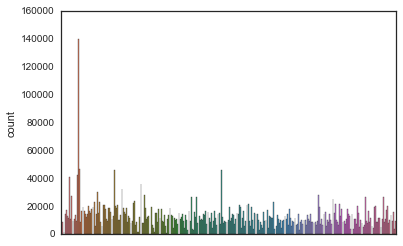

In [16]:
# Build plot with count of permits per cluster
ax=sns.countplot(x="cluster", data=permit_data.sort('cluster'), palette="husl");
ax.get_xaxis().set_visible(False)
ax.set_xlabel('clusters')
plt.savefig('./Plots/Cluster_counts_'+str(num_clusters)+'.png', dpi=3000)

# Only uncomment if you want to print the actual numbers
#permit_data['cluster'].value_counts()

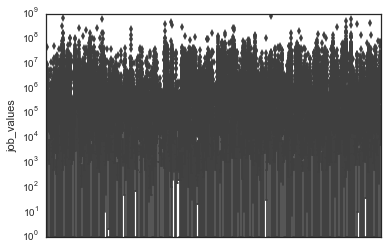

In [18]:
# Build boxplot of job-values across clusters
permit_sub=permit_data[(permit_data.job_values != 0)][['job_values','cluster']]
ax1=sns.boxplot(x="cluster", y="job_values", data=permit_sub.sort("cluster"),palette="husl");
ax1.get_xaxis().set_visible(False)
ax1.set_xlabel('clusters')
plt.yscale('log')
plt.savefig('./Plots/Job_Val_Box'+str(num_clusters)+'.png', dpi=3000)

# Show actual numbers and save them to a file
grouped = permit_sub['job_values'].groupby(permit_sub['cluster']) #group by cluster for aggregation purposes
grouped.describe().to_csv('./Plots/'+str(num_clusters)+'DescriptionStats.csv')